In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as I

In [12]:
def atmosphere_model(altitude):
    global altx,deny
    return np.interp(altitude, altx, deny)

In [13]:
def planet_parameters():
    G = 6.6742*10**-11; #%%Gravitational constant
    Mkerbin = 5.2915158*10**22 #
    muKerbin = G*Mkerbin
    Rkerbin = 600000 #meters
    sidereal_period = 21549.425
    sidereal_angular_velocity = 2*np.pi/sidereal_period
    sidereal_rotational_velocity = 174.94 #m/s
    mu = 3530.461 # km^3 / s^2 - gravitational parameter of parent bidy
    surface_gravity = 9.81 # m/s^2
    R = 600000 #m - radius of parent body
    return sidereal_rotational_velocity, mu, surface_gravity,R

In [31]:
def derivatives(state,t):
    x = state[0]
    z = state[1]
    velocity_x = state[2]
    velocity_z = state[3]
    mass = state[4]
    
#     kinematics
    x_dot = velocity_x
    z_dot = velocity_z
    
#     Gravitational Acceleration
    rSat = np.sqrt((x**2) + (z**2)) # rSat is radius to vessel
    sidereal_rotational_velocity, mu, surface_gravity,R = planet_parameters()
    if rSat < 1:
        gravx = 0.0
        gravz = 0.0
    else:
        gravx = -mu * x / (rSat**3)
        gravz = -mu * z / (rSat**3)
        
    altitude = rSat - R
    
    if altitude < 0:
        rho = 1.0
    else:
        rho = atmosphere_model(altitude)
        
    qinf = -np.pi * rho * S * Cd/mass
    aero_x = qinf * abs(velocity_x)* velocity_x
    aero_z = qinf * abs(velocity_z)* velocity_z
    
    if t > stage_1_time:
        thrust_x = 0.0
        thrust_z = 0.0
    else:
        if GNC:
            thrust = T1 * 1000.00
            theta = 90.0 * altitude / apogee
            if theta > 90.0:
                theta = 90.0
            thrust_x = thrust * np.cos(theta * np.pi / 180.0)
            thrust_z = thrust * np.sin(theta * np.pi / 180.0)
        else:
            thrust_x = T1 * 100
            thrust_z = 0.0
            
    if t > stage_2_start and t < stage_2_end:
        thrust = T2 * 1000.0
        thetaSat = np.arctan(z,x)
        
        thrust_x = thrust * np.sin(thetaSat)
        thrust_z = thrust * np.cos(thetaSat)
        
    if mass < 1.0:
        thrust_x = 0.0
        thrust_z = 0.0
        
    thrust = np.sqrt(thrust_z**2 + thrust_x**2)
    if abs(thrust) > 0:
        
        ve = Isp * abs(surface_gravity)
        mdot = -thrust/ve
    else: 
        mdot = 0.0
        
    xdbldot = thrust_x / mass + gravx + aero_x
    zdbldot = thrust_z / mass + gravz + aero_z
        
    statedot = np.asarray([x_dot,z_dot,xdbldot,zdbldot,mdot])
    if altitude < 0:
        statedot = np.asarray([0,0,0,0])
        
    return statedot

In [16]:
atm_model = np.loadtxt('kerbin_atmosphere.txt')
altx = atm_model[:,0]
deny = atm_model[:,3]

sidereal_rotational_velocity, mu, surface_gravity, R = planet_parameters()

In [36]:
###Let's make an orbit
desired_orbit_altitude_km = 70. #kilometers
r = R + desired_orbit_altitude_km*1000.
vorbit = np.sqrt(mu/r)
##Vorbit for 70 km is 2,295.9 m/s <- this is the delta v we 
#need to get to orbit
##Initial conditions in orbit
x0 = r
z0 = 0.
velx0 = 0.0
velz0 = vorbit
T1 = 0.0
Isp = 0.0
Cd = 0.0
S = 0.0
masstons = 5.3
stage_1_time = -99
stage_2_start = -99
stage_2_end = -99
#Orbit Time
semi_major = r
period = 2*np.pi/np.sqrt(mu)*semi_major**(3.0/2.0)
GNC = 0

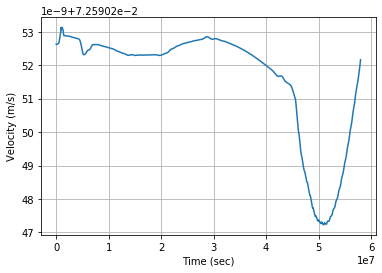

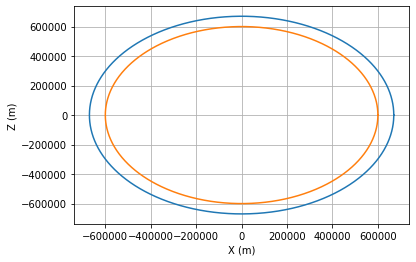

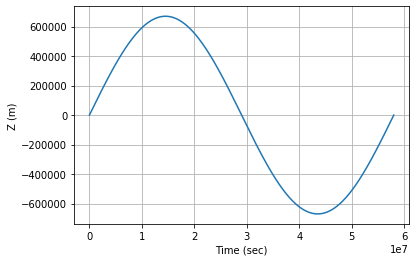

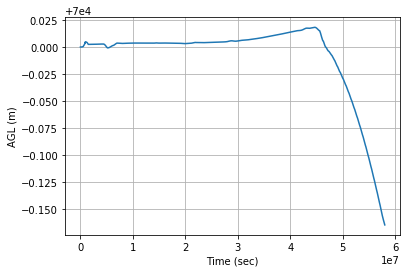

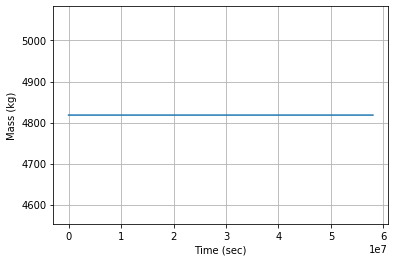

In [37]:
mass0 = masstons*2000/2.2
tout = np.linspace(0,period,100000)  #linspace(start,end,number of data points)
stateinitial = np.asarray([x0,z0,velx0,velz0,mass0])
stateout = I.odeint(derivatives,stateinitial,tout) ##This is the ode toolbox from scipy (Scientific Python)

xout = stateout[:,0]
zout = stateout[:,1]
vxout = stateout[:,2]
vzout = stateout[:,3]
mout = stateout[:,4]

vout = np.sqrt(vxout**2+vzout**2)

plt.figure()
plt.plot(tout,vout)
plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Velocity (m/s)')

plt.figure()
plt.plot(xout,zout)
thetakerbal = np.linspace(0,2*np.pi,1000)
xkerbal = R*np.cos(thetakerbal)
zkerbal = R*np.sin(thetakerbal)
plt.plot(xkerbal,zkerbal)
plt.grid()
plt.xlabel('X (m)')
plt.ylabel('Z (m)')

plt.figure()
plt.plot(tout,zout)
plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Z (m)')

plt.figure()
plt.plot(tout,np.sqrt(xout**2+zout**2)-R)
plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('AGL (m)')

plt.figure()
plt.plot(tout,mout)
plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Mass (kg)')

plt.show()